### 2023年度，確率ロボティクス課題
ロボットのための推定や行動決定アルゴリズムについてのシミュレーション

動作環境
- Ubuntu 22.04 LTS
- Python 3.10.12

参考書籍：「つくりながら学ぶ！深層強化学習」，著者：株式会社電通国際情報サービス 小川雄太郎，出版社：マイナビ出版

アルゴリズムの概要


In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 迷路の描画を行う

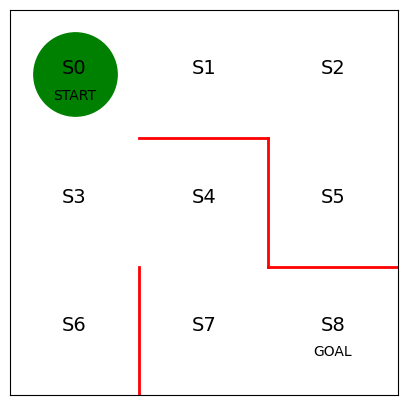

In [34]:
# 図の大きさと図の変数名
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字（S0~S8）
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲と目盛り削除
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# S0に緑色の丸を描画
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

迷路内を緑色で示されたエージェントがランダムに移動してゴールを目指す処理と移動する様子をアニメーションで可視化する処理

In [35]:
# 初期の方策を決定するパラメータtheta_0を設定

# 表形式表現：行は状態s（S0〜S8）を，列は行動a（↑，→，↓，←）を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],         # s0
                    [np.nan, 1, np.nan, 1],         # s1
                    [np.nan, np.nan, 1, 1],         # s2
                    [1, 1, 1, np.nan],              # s3
                    [np.nan, np.nan, 1, 1],         # s4
                    [1, np.nan, np.nan, np.nan],    # s5
                    [1, np.nan, np.nan, np.nan],    # s6
                    [1, 1, np.nan, np.nan],         # s7
                    ])                              # s8はゴールなので方策なし

In [36]:
# 初期の行動価値関数Q

[a, b] = theta_0.shape  # 行と列の数をa,bに格納
Q = np.random.rand(a, b) * theta_0
# theta_0を掛けることで，生成した乱数のうち壁方向に対応するものをnp.nanにする

In [38]:
# 方策パラメータtheta_0をランダム方策piに変換する関数

def simple_convert_info_pi_from_theta(theta):
    [m, n] = theta.shape    #thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :]) # 割合の計算
        
    pi = np.nan_to_num(pi)  #nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_info_pi_from_theta(theta_0)

In [39]:
# ε-greedy法


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]   # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

In [32]:
# 初期の方策pi_0を求める
# pi_0 = simple_canvert_info_pi_from_theta(theta_0)
pi_0 = simple_convert_info_pi_from_theta(theta_0)
# 初期の方策pi_0を表示
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]
